# Engrailed Detector Analysis

<a href="https://githubtocolab.com/alsinmr/pyDR_tutorial/blob/main/misc/Engrailed.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

In [1]:
import sys
if 'google.colab' in sys.modules: #Running on Colab
    !git clone https://github.com/alsinmr/pyDR.git
else: #Running on my computer
    sys.path.append('/Users/albertsmith/Documents/GitHub/')
    
import pyDR
import numpy as np
from copy import copy
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt

pyDR.Defaults['zrange']=[-12,-8,200]

Data provided by Fabien Ferrage, from:

Khan, Charlier, Augustyniak, Salvi, Déjean, Bodenhausen, Lequin, Pelupessy, Ferrage. "Distribution of Pico- and Nanosecond Motions in Disordered Proteins from Nuclear Spin Relaxation." **2015**, *Biophysical J.*, 109, 988-989

## Detectors concept|

The set of experiments used for engrailed is 5 $^{15}$N T$_1$ experiments, 5 heteronuclear NOEs, and 2 T$_2$ measurements (actually, I think we calculated T$_2$ from cross-correlated cross-relaxation. We do support ccZ/ccXY now, but when we did this analysis, we didn't have that implemented, so we just calculated what T$_2$ should be).

In [2]:
data=pyDR.IO.readNMR('https://drive.google.com/file/d/17NurbP4k7ESZijw4elAwAh-s4UmMj3WG/view?usp=sharing')

The basic idea behind detectors is that each experiment has a function describing how sensitive it is to each correlation time. Below, the first five curves correspond to the NOEs, the second 5 to the T$_1$s, and the last two (almost on top of each other) correspond to the T$_2$s. Then, data may be recombined to yield more separated ranges of correlation times. Note that the sensitivies of each experiment have been normalized to 1.

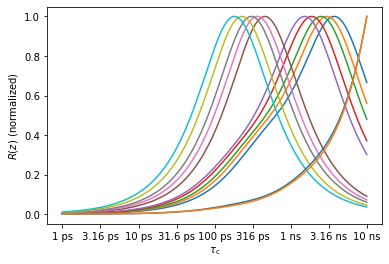

In [21]:
data.sens.plot_Rz(norm=True);

In principle, the 12 sensitivities above represent 12 potential fit parameters, but there is a lot of redundancy, so we want to reduce the number of parameters. Usually, one fits such a data set with 6 parameters, although actually only 5 of those are independent (the 6th comes from knowing that the order parameter must be zero). So we reduce the above curves first to 5 functions via singular value decomposition.

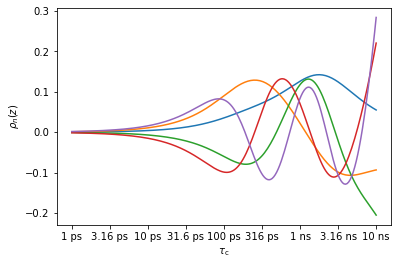

In [4]:
r=data.sens.Detector()
r.r_no_opt(5)
r.plot_rhoz();

These aren't particularly useful on their own, so we do a second step, where we recombine the 5 curves to get 5 positive, well-separated functions. We also add one more curve, considering that we do know the order parameter is 0 (total amplitude is 1)

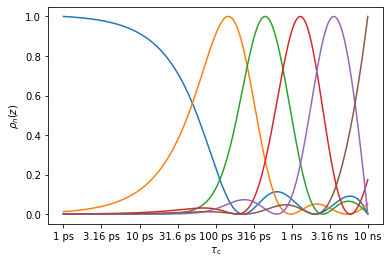

In [22]:
r.r_auto(5).inclS2()
r.plot_rhoz();

## Detectors fit

Finally, with optimized detectors, we can fit and plot the detector analysis of the engrailed data

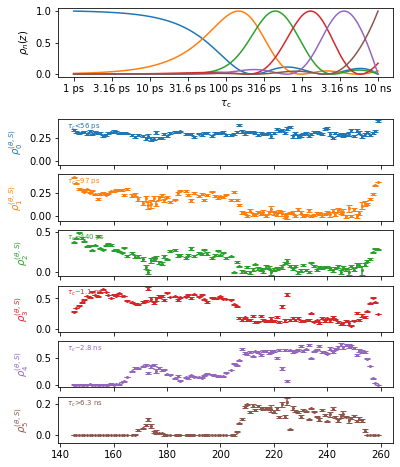

In [34]:
data.detect.r_auto(5).inclS2()  #This is the fit setup (how many detectors, and use S2, which equals 0)
fit=data.fit()  #This is the actual fit
po=fit.plot(style='scatter',markersize=2,errorbars=True)
po.fig.set_size_inches([6,8])
for a in po.ax:a.set_ylim([-.05,a.get_ylim()[1]])
po.show_tc()

In [32]:
print('rho0: max undefined, center undefined')
for k in range(1,5):
    print(f'rho{k}: max={fit.sens.tc[np.argmax(fit.sens.rhoz[k])]*1e9:5.3} ns, center={10**fit.sens.info["z0"][k]*1e9:5.3} ns')
print('rho4: max undefined, center undefined')

rho0: max undefined, center undefined
rho1: max=0.148 ns, center=0.0971 ns
rho2: max= 0.45 ns, center= 0.44 ns
rho3: max=  1.3 ns, center= 1.12 ns
rho4: max= 3.61 ns, center= 2.78 ns
rho4: max undefined, center undefined


What this tells us is that for each "sensitivity window" at the top, we find a certain amount of motion within that window, given for each window in the plots below. We see that for disordered regions, motion is faster, and becomes isotropic at shorter correlation times, but for the helical region (~205-250), we see a more global, slower motion in the nanosecond ($\rho_4$, ~2.8 ns) range.

The detectors are less noisy than IMPACT (paper here: http://dx.doi.org/10.1016/j.bpj.2015.06.069, see Figure 4). I think particularly obvious is that detectors yield a nearly uniform fast dynamics, as one would expect for local motion, whereas IMPACT yields much more variance, and that behavior continues at longer correlation times. I think it's not really optimal to use log-spaced correlation times in IMPACT; one should really place the correlation times individually based on where the experiments are most sensitive (which is sort of what detectors do). 

We can also evaluate the quality of the data fit with detectors, seen below, where bars with error bars are the input data and scatter points are the fit.

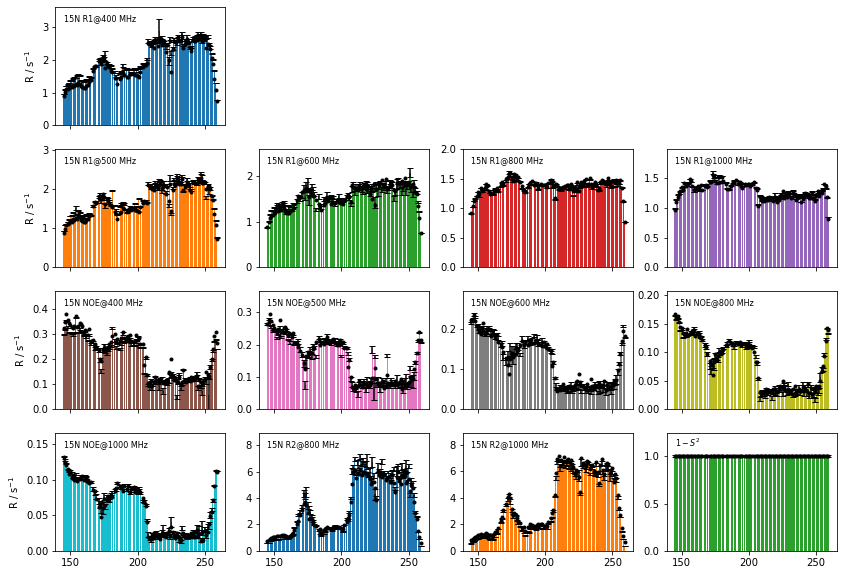

In [8]:
fit.plot_fit()[0].figure.set_size_inches([14,10])

So, the main advantage of the detectors is that there is a well-defined relationship between the distribution of correlation times of motion and the detector amplitudes ('detector responses'). We usually denote this distribution as $\theta(z)$, where $z$ is the log-correlation time ($z=\log_{10}(\tau_c / s)$). The distribution integrates to 1, and yields the reorientational correlation function as follows:
\begin{equation}
C(t)=\int\limits_{-\infty}^\infty{\theta(z)\exp{\left(-t/(10^z\cdot1\mathrm{ s})\right)}dz}
\end{equation}

Then, a given detector response results from the sensitivity of the detector (those are the functions at the top of the detector plot), denoted as $\rho_n(z)$, and the distribution, $\theta(z)$

\begin{equation}
\rho_n^{\theta}=\int\limits_{-\infty}^\infty{\rho_n(z)\theta(z)dz}
\end{equation}

So, the reason to bother with any of this is that the parameters we get from our data are well-defined. That's not really true with model-free, where to know what parameters are yielded from a given set of experiments and given distribution, $\theta(z)$, you basically have to calculate the experimental parameters and fit them with model free approach. Spectral density mapping is well-defined, but you're limited to one field data in the standard approach. 

This gets particularly important when you have data from unlike-sources. Our usual case is NMR+MD. So, if we happend to have MD data (I do not for Engrailed), we can calculate the correlation functions from MD, and also analyze these with detectors. 

Suppose I had an MD, sampled every 5 ps, out to 100 ns. Then, I have a set of "experiments", with some of the sensitivities plotted below.

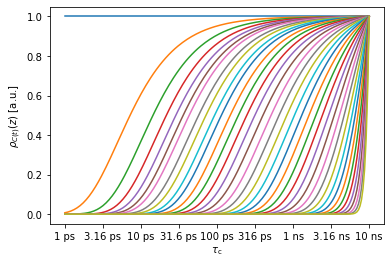

In [11]:
md=pyDR.Sens.MD(t=np.arange(int(100/.005))*.005)
md.plot_rhoz();

From this, we could optimize detectors simply to provide the maximum information:

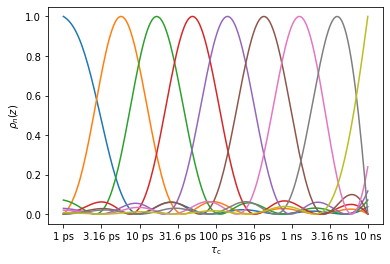

In [14]:
r_md=md.Detector()
r_md.r_auto(9)
r_md.plot_rhoz();

Or, we could try to match the detectors to the experimental ones, which is how we do quantitative comparison between unlike methods.

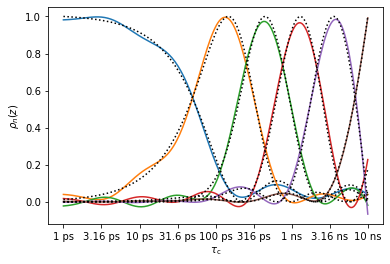

In [19]:
r_md.r_target(fit.sens.rhoz,n=9)
ax=r_md.plot_rhoz(index=np.arange(6))[0].axes
fit.sens.plot_rhoz(ax=ax,color='black',linestyle=':')

We have to trade noiseness of the analysis for precision of the detector matching by adjusting n, but in general, we can usually get a pretty good reproduction with good signal to noise, except where the MD simulation is not long enough to reproduce certain detectors (a more common problem in solid-state, where the $R_{1\rho}$ data is sensitive out to tens of microseconds.

So, the difficult question is, what good does it do to put fluorescence (possibly FRET) data into detector analysis? And I'm not sure yet– I need to get a better idea what part of the FCS correlation function is not covered by quantum effects, and how useful it is to compare similar detector windows from FCS, even though they are also reporting on distance modulation.